In [238]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [239]:
language = 'en'
assert(language in ['en', 'fr', 'es'])

In [240]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [241]:
len(numberbatch.vocab)

516782

In [242]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [243]:
ds_techniques = pd.read_csv('datasets/silknow/en_material_post2.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,"Silk brocade textile, Varanasi, 19th Century.",'gold thread'
1,Woman's kaftan. The fabric is silk woven with ...,'gold thread'
2,Woven with cut silk pile on a ground enriched ...,'silver thread'
3,"Seal bag of green silk velvet, lined with leat...",'silver thread'
4,Many decorative early 17th century bags surviv...,'silver thread'


In [244]:
ds_techniques.label.value_counts()

'silver thread'    176
'gold thread'      125
Name: label, dtype: int64

In [245]:
len(ds_techniques)

301

In [246]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [247]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [248]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [249]:
sorted(ds_techniques.label.unique())

["'gold thread'", "'silver thread'"]

In [250]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'musical_artist', 'tea_rose', 'rosa_laevigata', 'rosebud', 'rose_colored', 'rosemaling', 'roseless', 'rosa_rubiginosa', 'rosaceae', 'rose_bowl', 'old_rose', 'rosé', 'шипшина', 'rosewater', 'roselike', 'roze', 'ruusa', 'roser', 'roseling', 'serviceberry', 'rosaniline', 'musk_rose', 'վարդենի', 'itburnu', 'rose_cold', 'compass_rose', 'rosa_pimpinellifolia', 'rising', 'quincite', 'roseness', 'rosewood', 'purple', 'rose_water', 'mahaleb', 'arctic_raspberry', 'rise', 'black_spot', 'jetbead', 'rous', 'rosehip', 'rosa_omeiensis', 'rose_topaz', 'roziero', 'redden', 'rosa_canina', 'amelanchier', 'rosaceous', 'rosa_foetida', 'lolajöb', 'thorn', 'rosed', 'rosarian', 'rosula', 'noisette', 'jack', 'ורדא', 'rosa_rugosa', 'rock_rose', 'rosa_damascena', 'rosen', 'english_rose', 'pop_music', 'pink', 'roseleaf', 'rose_cut', 'china_rose', 'hawthorn', 'mawar', 'rooj', 'garden', 'rose_window', 'rose_syrup', 'red', 'hybrid_tea', 'rosulate', 'rosebush', 'rose_slug', 'compass_card', 'rose_ch

In [251]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 
            "'silver thread'": "silver",
            "'gold thread'": "gold",
}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

2
['gold', 'silver']


In [252]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 1.46 s, sys: 40.3 ms, total: 1.5 s
Wall time: 1.5 s


In [253]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'gold': 479, 'silver': 650}

In [254]:
labels_cgr.keys()

dict_keys(['gold', 'silver'])

In [255]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [256]:
ds_techniques.text[0]

'Silk brocade textile, Varanasi, 19th Century.'

In [257]:
data_silknow = ds_techniques.text.tolist()

In [258]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [259]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 45.9 ms, sys: 1.71 s, total: 1.75 s
Wall time: 1.45 s


In [260]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [261]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [262]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 28.3 ms, sys: 1.44 s, total: 1.47 s
Wall time: 1.33 s


In [263]:


predictions[:10]

[0, 1, 1, 1, 1, 0, 1, 0, 0, 1]

In [264]:

prediction_labels = [labels[p] for p in predictions]

In [265]:
set(prediction_labels)

{'gold', 'silver'}

In [266]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Materials

In [267]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('techniques-es-predictions.csv')

              precision    recall  f1-score   support

        gold      0.960     0.571     0.716       210
      silver      0.489     0.945     0.644        91

    accuracy                          0.684       301
   macro avg      0.724     0.758     0.680       301
weighted avg      0.817     0.684     0.695       301



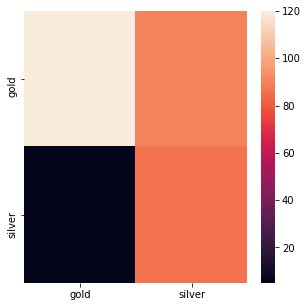

In [268]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [269]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        gold      1.000     1.000     1.000       125
      silver      1.000     1.000     1.000       176

    accuracy                          1.000       301
   macro avg      1.000     1.000     1.000       301
weighted avg      1.000     1.000     1.000       301



In [270]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        gold      1.000     1.000     1.000       125
      silver      1.000     1.000     1.000       176

    accuracy                          1.000       301
   macro avg      1.000     1.000     1.000       301
weighted avg      1.000     1.000     1.000       301

